##### Chapter 2 – The Main Challenges of Machine Learning
The data involves *Better Life Index* data from the [OECD’s website](https://data-explorer.oecd.org/vis?tenant=archive&df[ds]=DisseminateArchiveDMZ&df[id]=DF_BLI&df[ag]=OECD&dq=...&to[TIME]=false) as well as stats about *GDP per capita* from the [IMF’s website](https://www.imf.org/en/Publications/SPROLLS/world-economic-outlook-databases#sort=%40imfdate%20descending).

###### Code Source: Hands-on ML with Scikit-Learn, Keras & TensorFlow by Aurélien Géron

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [4]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

The below function just merges the OECD's life satisfaction data and the IMF's GDP per capita data.

In [21]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
    missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]
    
    return full_country_stats[["GDP per capita", 'Life satisfaction']], sample_data, missing_data

In [6]:
import os
datapath = os.path.join("datasets", "lifesat", "")

In [7]:
# To plot figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

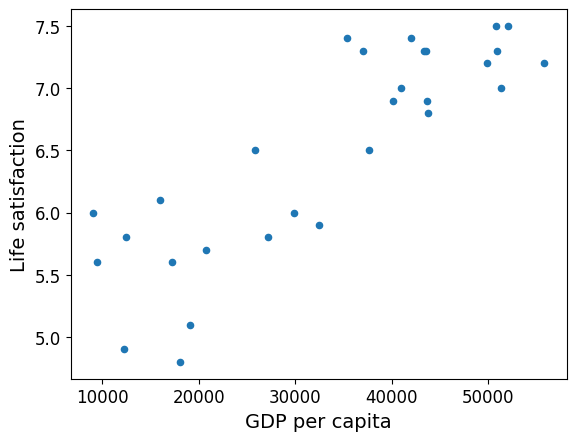

In [22]:
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

backup = oecd_bli, gdp_per_capita

# Prepare the data
full_country, select_country, missing_country = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[select_country["GDP per capita"]]
y = np.c_[select_country["Life satisfaction"]]

# Visualize the data
select_country.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)
t0, t1 = model.intercept_[0], model.coef_[0][0]

Create a function to save the figures.

In [24]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Make this notebook's output stable across runs:

In [14]:
np.random.seed(42)

In [12]:
missing_country

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


##### Challenge caused by "Bad Data": Nonrepresentative Training Data
The linear model changes drastically if the training set we use is not representative of the entire dataset.

In [13]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

Saving figure representative_training_data_scatterplot


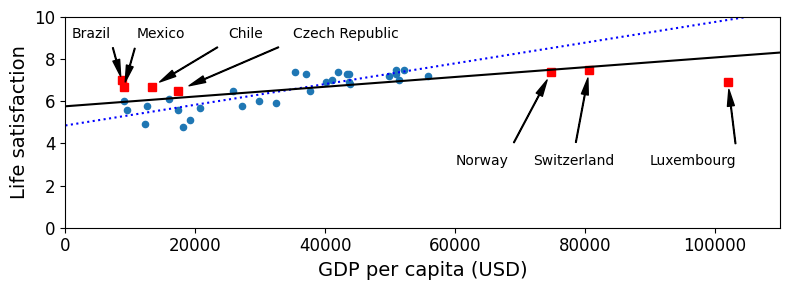

In [40]:
select_country.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_country.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

lin_reg_full = sklearn.linear_model.LinearRegression()
Xfull = np.c_[full_country["GDP per capita"]]
yfull = np.c_[full_country["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

##### Challenge caused by "Bad Algorithm": Overfitting Training Data

Saving figure overfitting_model_plot


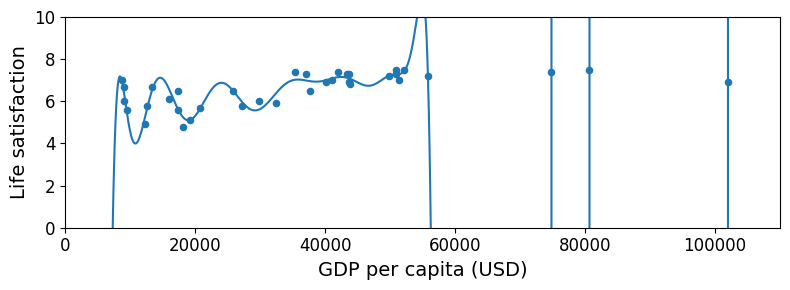

In [32]:
full_country.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=30, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = sklearn.linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

##### Regularization reduces the risk of overfitting

In [34]:
full_country.loc[[c for c in full_country.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.2
Norway         7.4
Switzerland    7.5
Name: Life satisfaction, dtype: float64

In [35]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if "W" in c.upper()]].head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Botswana,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6040.957,2008.0
Kuwait,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",29363.027,2014.0
Malawi,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",354.275,2011.0
New Zealand,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",37044.891,2015.0
Norway,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",74822.106,2015.0


Saving figure ridge_model_plot


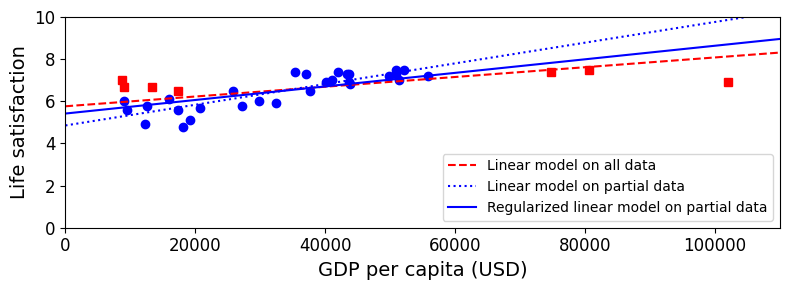

In [39]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

plt.plot(list(select_country["GDP per capita"]), list(select_country["Life satisfaction"]), "bo")
plt.plot(list(missing_country["GDP per capita"]), list(missing_country["Life satisfaction"]), "rs")

X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

ridge = sklearn.linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[select_country["GDP per capita"]]
ysample = np.c_[select_country["Life satisfaction"]]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()